In [382]:
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(styles[3])

In [101]:
train_data, test_data = pd.read_csv('../data/class_train.csv'), pd.read_csv('../data/class_test.csv')

In [234]:
data = pd.concat([train_data, test_data], ignore_index = True)

In [236]:
data.head()

,Plasma renin activity,Aldosterone-to-renin ratio -more detailed ranges in Aldosterone/renin ratio article,Oxygen saturation,17α-Hydroxyprogesterone,Anti ds-DNA,Reticulocyte hemoglobin equivalent,Fibrinogen,Procalcitonin,SHBG -more detailed ranges in SHBG article,[H+],...,Luteinizing hormone (LH)-more detailed menstrual cycle ranges in separate diagram,Alpha 1-antitrypsin (AAT),Eosinophil cationic protein (ECP),Absolute content of carbon dioxide (CO2),Chloride (Cl),Amylase,IgM,Copper (Cu),Viscosity,Outcome
0,955.281824,6.008015,7.679162,8181.376094,637.176162,1655.935340,5572.232595,295.898724,8168.540684,1912.478041,...,9919.820568,4.764464,1911.290743,4.793836,7405.484356,10.522503,4644.152278,3.086409,7269.046415,0
1,1230.105982,16.004716,13.758903,10160.744348,826.173179,2005.291945,6645.645696,367.173919,9936.287732,2597.155427,...,12058.542281,21.412708,2225.412113,5.465201,8928.703718,20.770201,5900.118535,12.234226,8818.661328,0
2,1368.526126,3.397476,5.733414,11757.239383,963.221156,2309.067904,8208.582321,437.166464,11233.856279,2918.152097,...,14481.374431,5.024250,2828.177336,2.918513,10384.582517,1.224893,6798.340905,17.303987,10614.577165,0
3,1127.887803,6.128786,5.891781,9134.772017,737.518529,1859.595041,6469.579061,340.152779,9009.068421,2392.056388,...,10919.936385,1.362570,2130.646124,2.115228,8229.748093,2.486947,5371.300693,19.875223,8077.366728,0
4,1279.789838,11.834707,2.035606,10233.512908,836.776751,2064.653384,7036.941075,377.650340,10082.609454,2723.896231,...,12106.667363,13.604294,2284.807267,1.553677,9033.725105,0.833231,6061.031816,11.714379,8916.594576,0


In [237]:
data.corr()

,Plasma renin activity,Aldosterone-to-renin ratio -more detailed ranges in Aldosterone/renin ratio article,Oxygen saturation,17α-Hydroxyprogesterone,Anti ds-DNA,Reticulocyte hemoglobin equivalent,Fibrinogen,Procalcitonin,SHBG -more detailed ranges in SHBG article,[H+],...,Luteinizing hormone (LH)-more detailed menstrual cycle ranges in separate diagram,Alpha 1-antitrypsin (AAT),Eosinophil cationic protein (ECP),Absolute content of carbon dioxide (CO2),Chloride (Cl),Amylase,IgM,Copper (Cu),Viscosity,Outcome
Plasma renin activity,1.000000,-0.042012,0.212894,0.975091,0.970170,0.983284,0.975153,0.966707,0.971856,0.949235,...,0.959543,0.078549,0.959473,-0.087870,0.967200,-0.034758,0.992627,0.033373,0.965612,0.264850
Aldosterone-to-renin ratio -more detailed ranges in Aldosterone/renin ratio article,-0.042012,1.000000,-0.001178,-0.043981,-0.058499,-0.043865,-0.040171,-0.050594,-0.053724,-0.042244,...,-0.046984,0.132594,-0.039269,0.052164,-0.021516,0.137131,-0.053458,-0.005766,-0.045257,-0.019848
Oxygen saturation,0.212894,-0.001178,1.000000,0.229980,0.241346,0.221445,0.206002,0.228796,0.233796,0.214136,...,0.232439,0.086107,0.227958,-0.023404,0.210327,0.166064,0.230522,-0.086368,0.234261,-0.044762
17α-Hydroxyprogesterone,0.975091,-0.043981,0.229980,1.000000,0.979381,0.986673,0.942577,0.957065,0.988835,0.899335,...,0.994863,0.069382,0.976238,-0.114598,0.986908,-0.047720,0.985394,0.042156,0.993791,0.258720
Anti ds-DNA,0.970170,-0.058499,0.241346,0.979381,1.000000,0.954908,0.952485,0.987142,0.956850,0.947006,...,0.962850,0.069481,0.961354,-0.099144,0.967741,-0.033972,0.990854,0.058074,0.966481,0.204218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Amylase,-0.034758,0.137131,0.166064,-0.047720,-0.033972,-0.056451,-0.045608,-0.034734,-0.059012,-0.012817,...,-0.058508,-0.059514,-0.059339,0.018614,-0.039357,1.000000,-0.040321,-0.078950,-0.059875,-0.059509
IgM,0.992627,-0.053458,0.230522,0.985394,0.990854,0.981041,0.974454,0.983368,0.976583,0.951096,...,0.972044,0.072812,0.971961,-0.095588,0.972494,-0.040321,1.000000,0.043337,0.977408,0.244384
Copper (Cu),0.033373,-0.005766,-0.086368,0.042156,0.058074,0.020610,0.039206,0.060272,0.020550,0.047471,...,0.033305,-0.017078,0.035426,-0.100534,0.053246,-0.078950,0.043337,1.000000,0.031680,-0.132301
Viscosity,0.965612,-0.045257,0.234261,0.993791,0.966481,0.990760,0.946518,0.947880,0.991478,0.887877,...,0.997692,0.068970,0.988034,-0.115950,0.976453,-0.059875,0.977408,0.031680,1.000000,0.275148


In [238]:
# Check all values in case of nan

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 160 entries, Plasma renin activity to Outcome
dtypes: float64(157), int64(3)
memory usage: 145.1 KB


# PCA

In [329]:
X = data.drop(columns = ['Outcome'])
Y = data['Outcome']

In [363]:
import numpy as np
from sklearn.decomposition import PCA


pca_all = PCA()
all_principal_components = pca_all.fit_transform(X)

pca = PCA(n_components = 4)
principal_components = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_sum = [value + sum(explained_variance_ratio[:i]) for i, value in enumerate(explained_variance_ratio)]
explained_variance_ratio_sum_n = list(zip([i+1 for i in range(len(explained_variance_ratio_sum))], explained_variance_ratio_sum))


In [533]:
l = list(np.arange(0.965,1, step = 0.005))
print(l)
l.insert(5,2)

[0.965, 0.97, 0.975, 0.98, 0.985, 0.99, 0.995, 1.0]


In [534]:
l

[0.965, 0.97, 0.975, 0.98, 0.985, 2, 0.99, 0.995, 1.0]

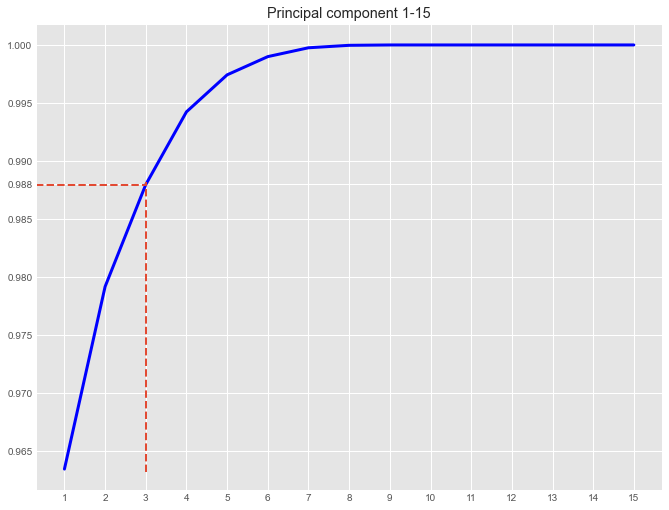

In [542]:
all_explained_variance_ratio_sum = [value + sum(pca_all.explained_variance_ratio_[:i]) for i, value in enumerate(pca_all.explained_variance_ratio_)]

n_components = 15

plt.figure(figsize = (10,8))
plt.plot([i+1 for i in range(len(all_explained_variance_ratio_sum[:n_components]))], all_explained_variance_ratio_sum[:n_components], linewidth = 3, color = 'blue')
plt.axhline(y=0.9879747749615931, xmin = 0, xmax = 0.175, linestyle = '--', linewidth = 2)
plt.axvline(x=3, ymin = 0.04, ymax = 0.661, linestyle = '--', linewidth = 2)

y_ticks = list(np.arange(0.965,1, step = 0.005))
y_ticks.insert(5,round(0.9879747749615931, 3))

plt.xticks([i+1 for i in range(n_components)]) 
plt.yticks(y_ticks)

plt.title(f'Principal component 1-{n_components}')
plt.show()


På plotten ovan kan vi se att vi med endast 3 st pc's kan representera 98.8% av den ursprunliga variansen i datan.

In [364]:
explained_variance_ratio_list_n

[(1, 0.9634790775580118),
 (2, 0.9791881827364936),
 (3, 0.9879747749615931),
 (4, 0.9942372052646697)]

In [546]:
pc_X = pd.DataFrame(principal_components, columns = [f'PC-{i+1}' for i in range(principal_components.shape[1])])

In [547]:
pc_data = pd.concat([pc_X, Y], axis = 1)

In [548]:
pc_data

,PC-1,PC-2,PC-3,PC-4,Outcome
0,-27981.928893,-33.021547,-250.912405,122.691009,0
1,-11285.216348,-4710.166049,626.030968,-1026.659241,0
2,284.740878,-4405.435496,-802.216950,-415.108579,0
3,-17958.573691,-2899.676342,-317.275796,521.904111,0
4,-8786.729083,-5402.852903,627.979243,-75.229891,0
...,...,...,...,...,...
111,-6504.428049,2498.073432,250.295001,-145.271206,1
112,-15206.520846,2006.304991,1145.995988,580.970678,1
113,-6261.853759,-2342.769486,1580.719560,48.970684,1
114,-20105.982722,342.309244,1585.425185,-928.485977,1


In [549]:
pc_data.corr()

,PC-1,PC-2,PC-3,PC-4,Outcome
PC-1,1.000000e+00,-1.916016e-16,1.238542e-16,2.226347e-17,0.260195
PC-2,-1.916016e-16,1.000000e+00,4.243597e-16,-1.791520e-16,0.088341
PC-3,1.238542e-16,4.243597e-16,1.000000e+00,8.680833e-17,0.326923
PC-4,2.226347e-17,-1.791520e-16,8.680833e-17,1.000000e+00,0.089155
Outcome,2.601947e-01,8.834087e-02,3.269229e-01,8.915478e-02,1.000000


In [550]:
pc_data['Outcome'].value_counts()

1    64
0    52
Name: Outcome, dtype: int64

In [552]:
X = pc_data.drop(columns = ['Outcome'])
Y = pc_data['Outcome']

In [598]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3, shuffle = True)

clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1,max_depth=1, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

score = clf.score(X_test, y_test)
feature_importance = clf.feature_importances_
conf_mat = confusion_matrix(y_test, predictions)
f1_score = f1_score(y_test, predictions, average='macro')

In [599]:
print(f'Training set (labels)\n{y_train.value_counts()}')
print()
print(f'Testing set (labels)\n{y_test.value_counts()}')

Training set (labels)
1    48
0    33
Name: Outcome, dtype: int64

Testing set (labels)
0    19
1    16
Name: Outcome, dtype: int64


In [600]:
print('Score:', score)
print('feature_importance:', feature_importance)
print('conf_mat:\n', conf_mat)
print('\nf1_score', f1_score)

Score: 0.6857142857142857
feature_importance: [0.18328902 0.19800911 0.47447777 0.14422409]
conf_mat:
 [[10  9]
 [ 2 14]]

f1_score 0.6815550041356493
